# **CIS 419/519**
## Convolutional Neural Networks





Learning Objectives:
* How to build a convolutional neural net in PyTorch
* Understand window size, stride, padding for convolutional layer
* Understand dropout layer and how it could avoid overfitting


In [ ]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt

# Loading the data

The cell below can take a few minutes to run.

In [ ]:
trainset = datasets.MNIST('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

# Visualize the dataset

The label is:  tensor(4)
The label is:  tensor(3)
The label is:  tensor(3)


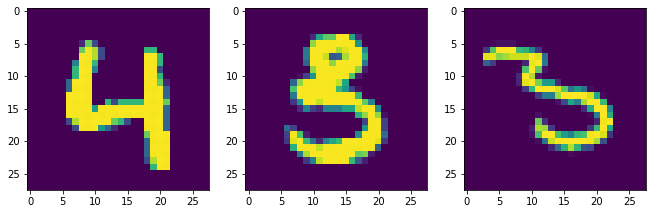

In [ ]:
images, labels = iter(trainloader).next()
fig=plt.figure(figsize=(15, 10))
for i in range(1, 4):
    fig.add_subplot(1, 4, i)
    plt.imshow(images[i].numpy().squeeze())
    print('The label is: ', labels[i])
plt.show()

As we can see below, we have 16 images with 1 channel (grayscale image, color images have 3 channels, i.e. RGB) that is 28×28 pixels. The size of the image will be important when designing the convolutional filters.

In [ ]:
print(images.shape)

torch.Size([16, 1, 28, 28])


# Convolutional Neural Networks (CNN)

The goal is to build a model that successfully classifies hand-written digits. 

The CNN model takes an image as input and outputs what number is this hand-written digit. To do this, we will use a **convolutional neural network (CNN)**, which is a particular kind of neural network commonly used for computer vision. CNNs are just like the normal feed-forward networks from the Neural Network Worksheet, except that they have some extra layers like convolutional layers, max-pooling layer, and so on.

Now, we'll walk through the different types of layers typically present in a CNN.

In [12]:
class CNN1(torch.nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        # TODO: Build model with 1 Conv2d layer and max pooling, then 2 linear layers
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm = torch.nn.BatchNorm2d(num_features=16)
        self.linear_1 = torch.nn.Linear(14 * 14 * 16, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # TODO: Complete the forward pass
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = self.batch_norm(x)
        x = x.reshape(x.size(0), -1) 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

cnn_model = CNN1()
print(sum(p.numel() for p in cnn_model.parameters() if p.requires_grad))

403018


Now we can train the model and look at the loss at every episode. 

In [13]:
epochs = 10
model = CNN1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# traing iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 453.8418
epoch: 2, loss: 175.6089
epoch: 3, loss: 103.2258
epoch: 4, loss: 74.3625
epoch: 5, loss: 59.4654
epoch: 6, loss: 47.7292
epoch: 7, loss: 44.6653
epoch: 8, loss: 42.6219
epoch: 9, loss: 26.4990
epoch: 10, loss: 34.7499


### More complex CNN: 
Here, we're going to create a CNN with 1 convolutional layer, max pooling, 2 linear layers and then we're going to apply dropout.

In [ ]:
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(14 * 14 * 32, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [ ]:
epochs = 10
model = CNN2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# traing iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 1268.1172
epoch: 2, loss: 547.8837
epoch: 3, loss: 401.5534
epoch: 4, loss: 322.5447
epoch: 5, loss: 283.1010
epoch: 6, loss: 249.2354
epoch: 7, loss: 209.8192
epoch: 8, loss: 189.7120
epoch: 9, loss: 175.1856
epoch: 10, loss: 162.1441


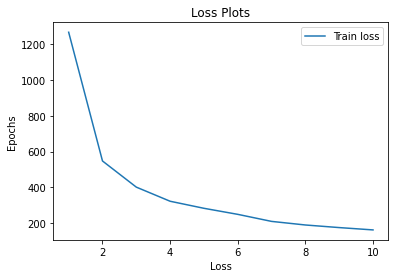

In [ ]:
fig=plt.figure()
plt.plot(np.arange(1, epochs+1), train_loss, label="Train loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

Now, test the accuracy of the model on the test set.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(testloader):
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9799
